In [1]:
# !pip install kagglehub

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

import kagglehub
DATASET_PATH = os.environ.get("DATASET_PATH") or kagglehub.dataset_download(
    'hkayan/industrial-robotic-arm-imu-data-casper-1-and-2') + '/'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import re
normalPattern = "IMU_(.*)Hz.csv"

normal = ("IMU_10Hz.csv", ("label", 0))
faulty =("IMU_hitting_platform.csv", ("label", 1))

df = pd.read_csv(DATASET_PATH + normal[0])
df['label'] = 0

faultydf = pd.read_csv(DATASET_PATH+faulty[0])
faultydf['label'] = 1



In [4]:
df.shape, faultydf.shape

((874937, 12), (14967, 12))

In [5]:
df.isnull().values.any()
# Sem NAs

np.False_

# PREPARAÇÂO DOS DADOS
- convertendo o timestamp de ns pra s
- aplicando filtragem Savitzky–Golay para reduzir o ruído dos sensores
- apresentar a quantidade alta de zeros nos sensores causada pelos frequentes momentos de inércia do braço

In [6]:
#ns pra ms
df['time'] = (df['time'].map(lambda x: x/1e6))
faultydf['time'] = faultydf['time'].map(lambda x: x/1e6)

print(f"A frequência é {1/(df['time'].diff().mean()/1000):.2f}Hz")

A frequência é 9.98Hz


In [7]:
df.columns,faultydf.columns

cols = ["accX", "accY","accZ","gyroX", "gyroY", "gyroZ", "magX", "magY", "magZ"]


In [8]:
df.loc[:, cols].describe( #remover time e label
        ).T.style.format("{:.4f}"
        ).background_gradient(cmap="Blues")

,count,mean,std,min,25%,50%,75%,max
accX,874937.0000,9.2692,1.5163,1.1564,9.3948,9.8521,9.9575,12.0668
accY,874937.0000,-0.6796,3.0819,-9.8474,-0.6728,-0.0383,0.2466,8.4755
accZ,874937.0000,0.4951,0.2348,-0.8356,0.3783,0.4956,0.5866,1.9082
gyroX,874937.0000,0.3487,28.0195,-81.7500,-4.0000,0.0000,1.1875,98.0625
gyroY,874937.0000,0.6639,8.0825,-27.8750,-0.3750,0.0000,0.1875,53.2500
gyroZ,874937.0000,0.0182,26.3745,-100.9375,-3.0625,0.0000,1.3125,114.1250
magX,874937.0000,-33.3438,5.8454,-51.6400,-35.9600,-35.1600,-32.2800,0.0000
magY,874937.0000,19.5896,19.2806,-48.7600,14.6800,30.2000,30.8800,40.9600
magZ,874937.0000,-2.4805,31.4547,-59.3846,-35.6154,6.6154,17.6923,52.7692


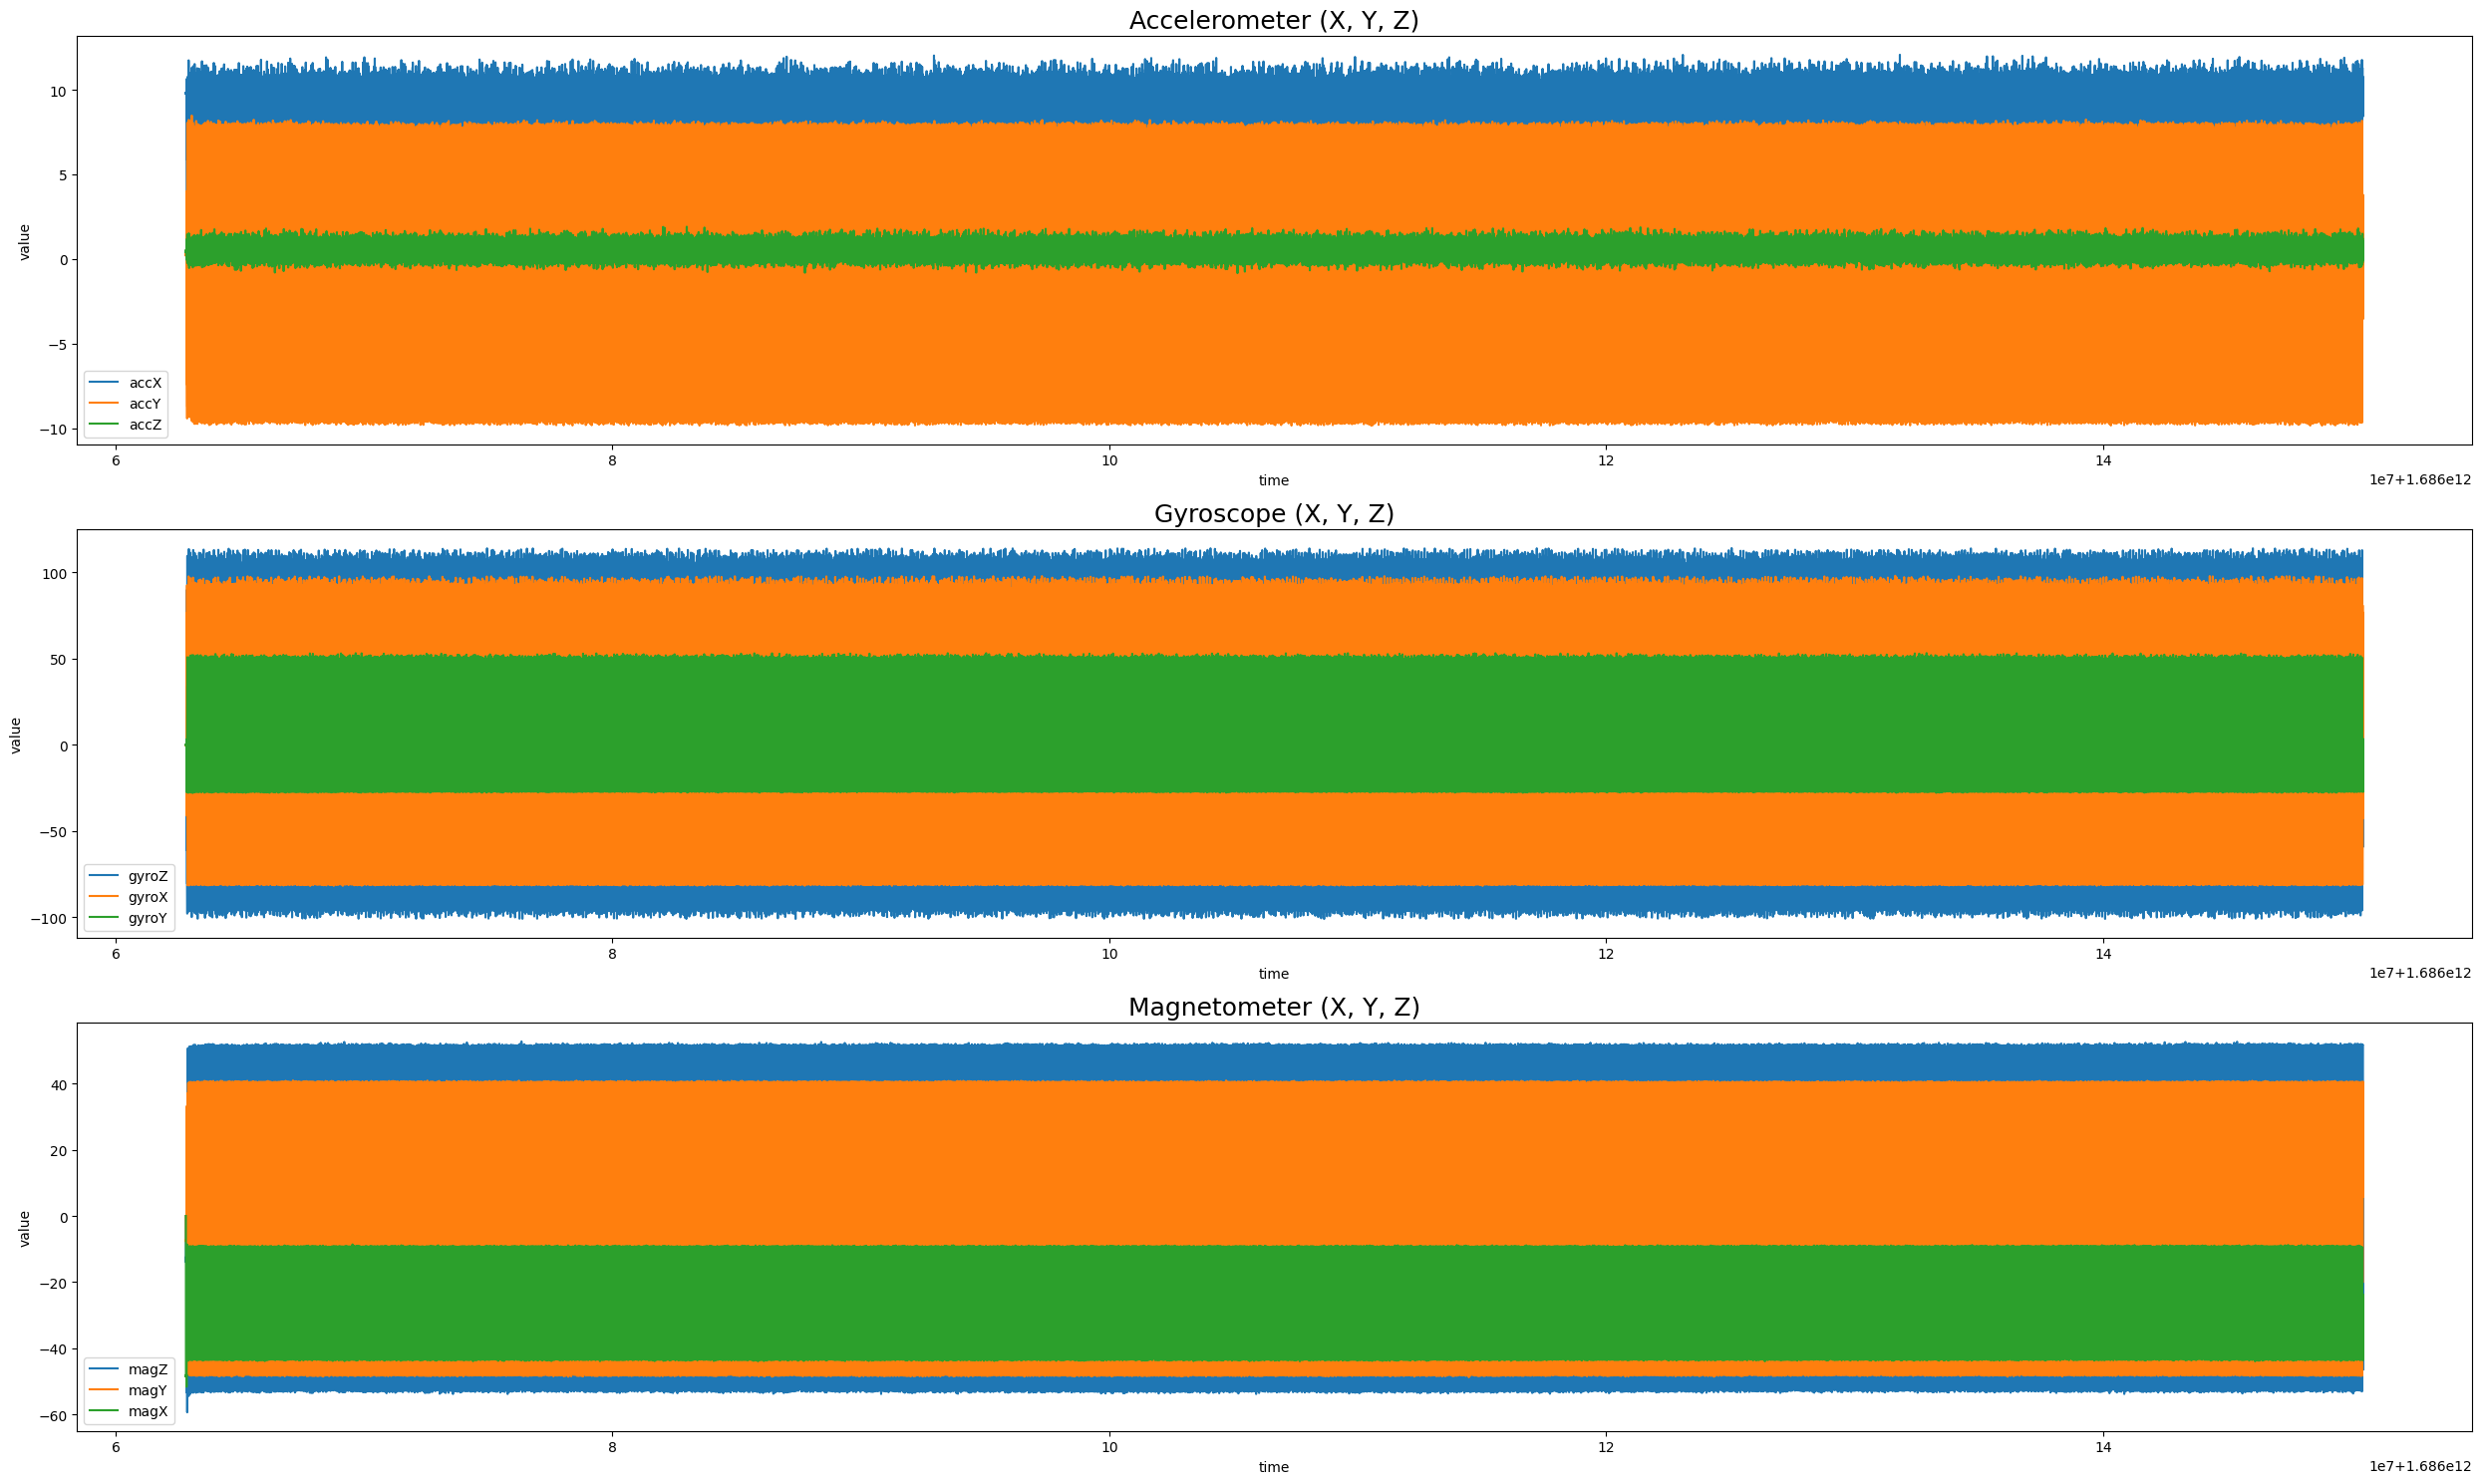

In [9]:
import matplotlib.pyplot as plt
def plotSensors(dfPlot, step=1):
    df = dfPlot.iloc[::step]
    fig = plt.figure(figsize=(25, 15))

    # Helper to plot three axes in the same subplot
    def plotSensorsSameGraph(ax, cols, title, x="time"):
        for col in cols:
            ax.plot(df[x], df[col], label=col)
        ax.set_title(title, fontsize=18)
        ax.set_xlabel(x)
        ax.set_ylabel("value")
        ax.legend(loc='lower left')

    # === Subplots ===
    ax1 = fig.add_subplot(3, 1, 1)
    plotSensorsSameGraph(ax1,
                         cols=["accX", "accY","accZ"],
                         title="Accelerometer (X, Y, Z)")

    ax2 = fig.add_subplot(3, 1, 2)
    plotSensorsSameGraph(ax2,
                         cols=["gyroZ","gyroX", "gyroY", ],
                         title="Gyroscope (X, Y, Z)")

    ax3 = fig.add_subplot(3, 1, 3)
    plotSensorsSameGraph(ax3,
                         cols=["magZ", "magY", "magX"],
                         title="Magnetometer (X, Y, Z)")

    plt.tight_layout()
    plt.show()
plotSensors(df)

In [10]:
from scipy.signal import savgol_filter
# Savitzky-golay, um filtro bom pra series temporais (inspirado por https://www.nixtla.io/blog/polynomial_filtering)
for col in cols:
  df[col + "_smooth"] = savgol_filter(df[col], window_length=8, polyorder=2)


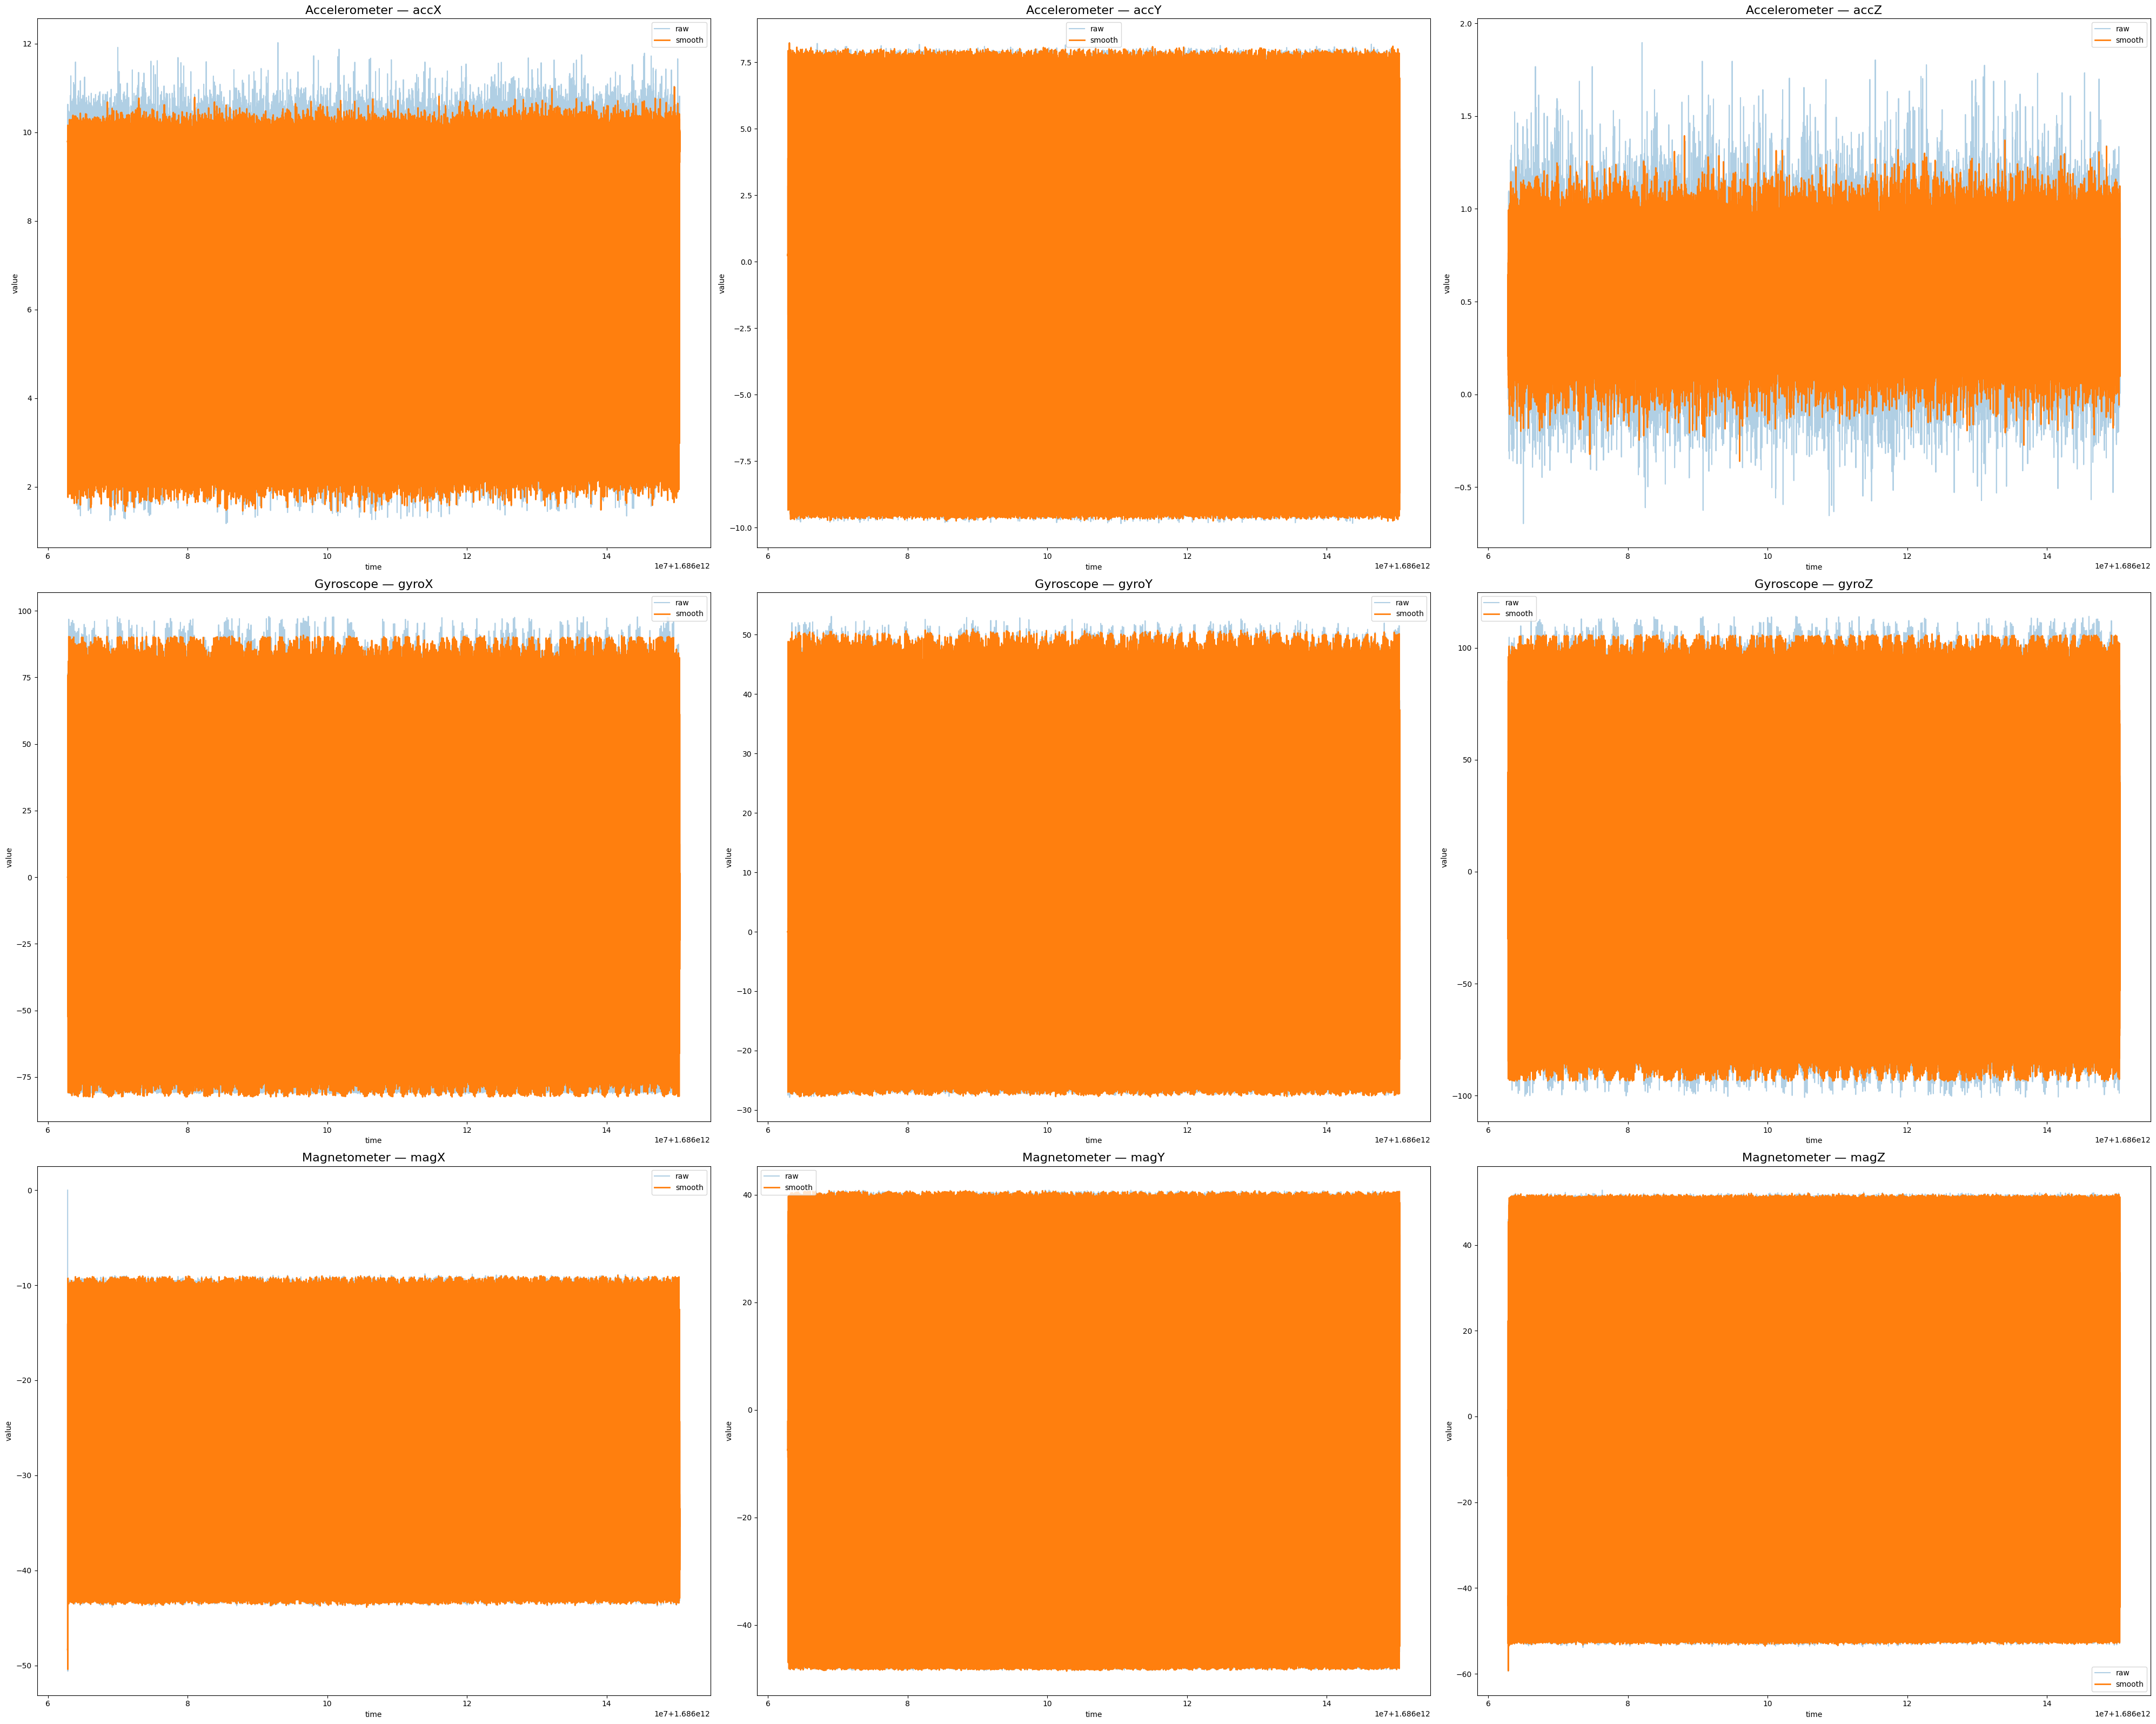

In [19]:
sensor_groups = [
    ("Accelerometer", ["accX", "accY", "accZ"]),
    ("Gyroscope", ["gyroX", "gyroY", "gyroZ"]),
    ("Magnetometer", ["magX", "magY", "magZ"])
]
def plot_raw_vs_smooth(df,step=10):
    fig, axes = plt.subplots(3, 3, figsize=(40, 32))
    df = df.iloc[::step]

    for row, (title, cols) in enumerate(sensor_groups):
        for col, axis in enumerate(cols):
            ax = axes[row][col]

            raw = df[axis]
            smooth = df[axis + "_smooth"]

            ax.plot(df["time"], raw, label="raw", alpha=0.35)
            ax.plot(df["time"], smooth, label="smooth", linewidth=2)

            ax.set_title(f"{title} — {axis}", fontsize=16)
            ax.set_xlabel("time")
            ax.set_ylabel("value")
            ax.legend()

    plt.tight_layout()
    plt.show()
plot_raw_vs_smooth(df)

## Comparação antes e depois da filtragem

1. adicionar a imagem aqui porque é muito lento pra calcular)

1. Adicionar metricas de ruído


## Normalização dos sinais com z-score

In [20]:
means = df[cols].mean()
stds = df[cols].std()

for col in cols:
    df[col + "_norm"] = (df[col] - means[col]) / stds[col]
    faultydf[col + "_norm"] = (faultydf[col] - means[col]) / stds[col]

In [21]:
def plot_raw_vs_normalized(dfPlot, step=10):
    fig, axes = plt.subplots(3, 3, figsize=(40, 16))
    df = dfPlot.iloc[::step]

    for row, (title, cols) in enumerate(sensor_groups):
        for col, axis in enumerate(cols):
            ax = axes[row][col]

            raw = df[axis]
            norm = df[axis + "_norm"]

            ax.plot(df["time"], raw, label="raw", alpha=0.35)
            ax.plot(df["time"], norm, label="normalized", linewidth=2)

            ax.set_title(f"{title} - {axis}", fontsize=16)
            ax.set_xlabel("time")
            ax.set_ylabel("value")
            ax.legend()


    plt.tight_layout()
    plt.show()

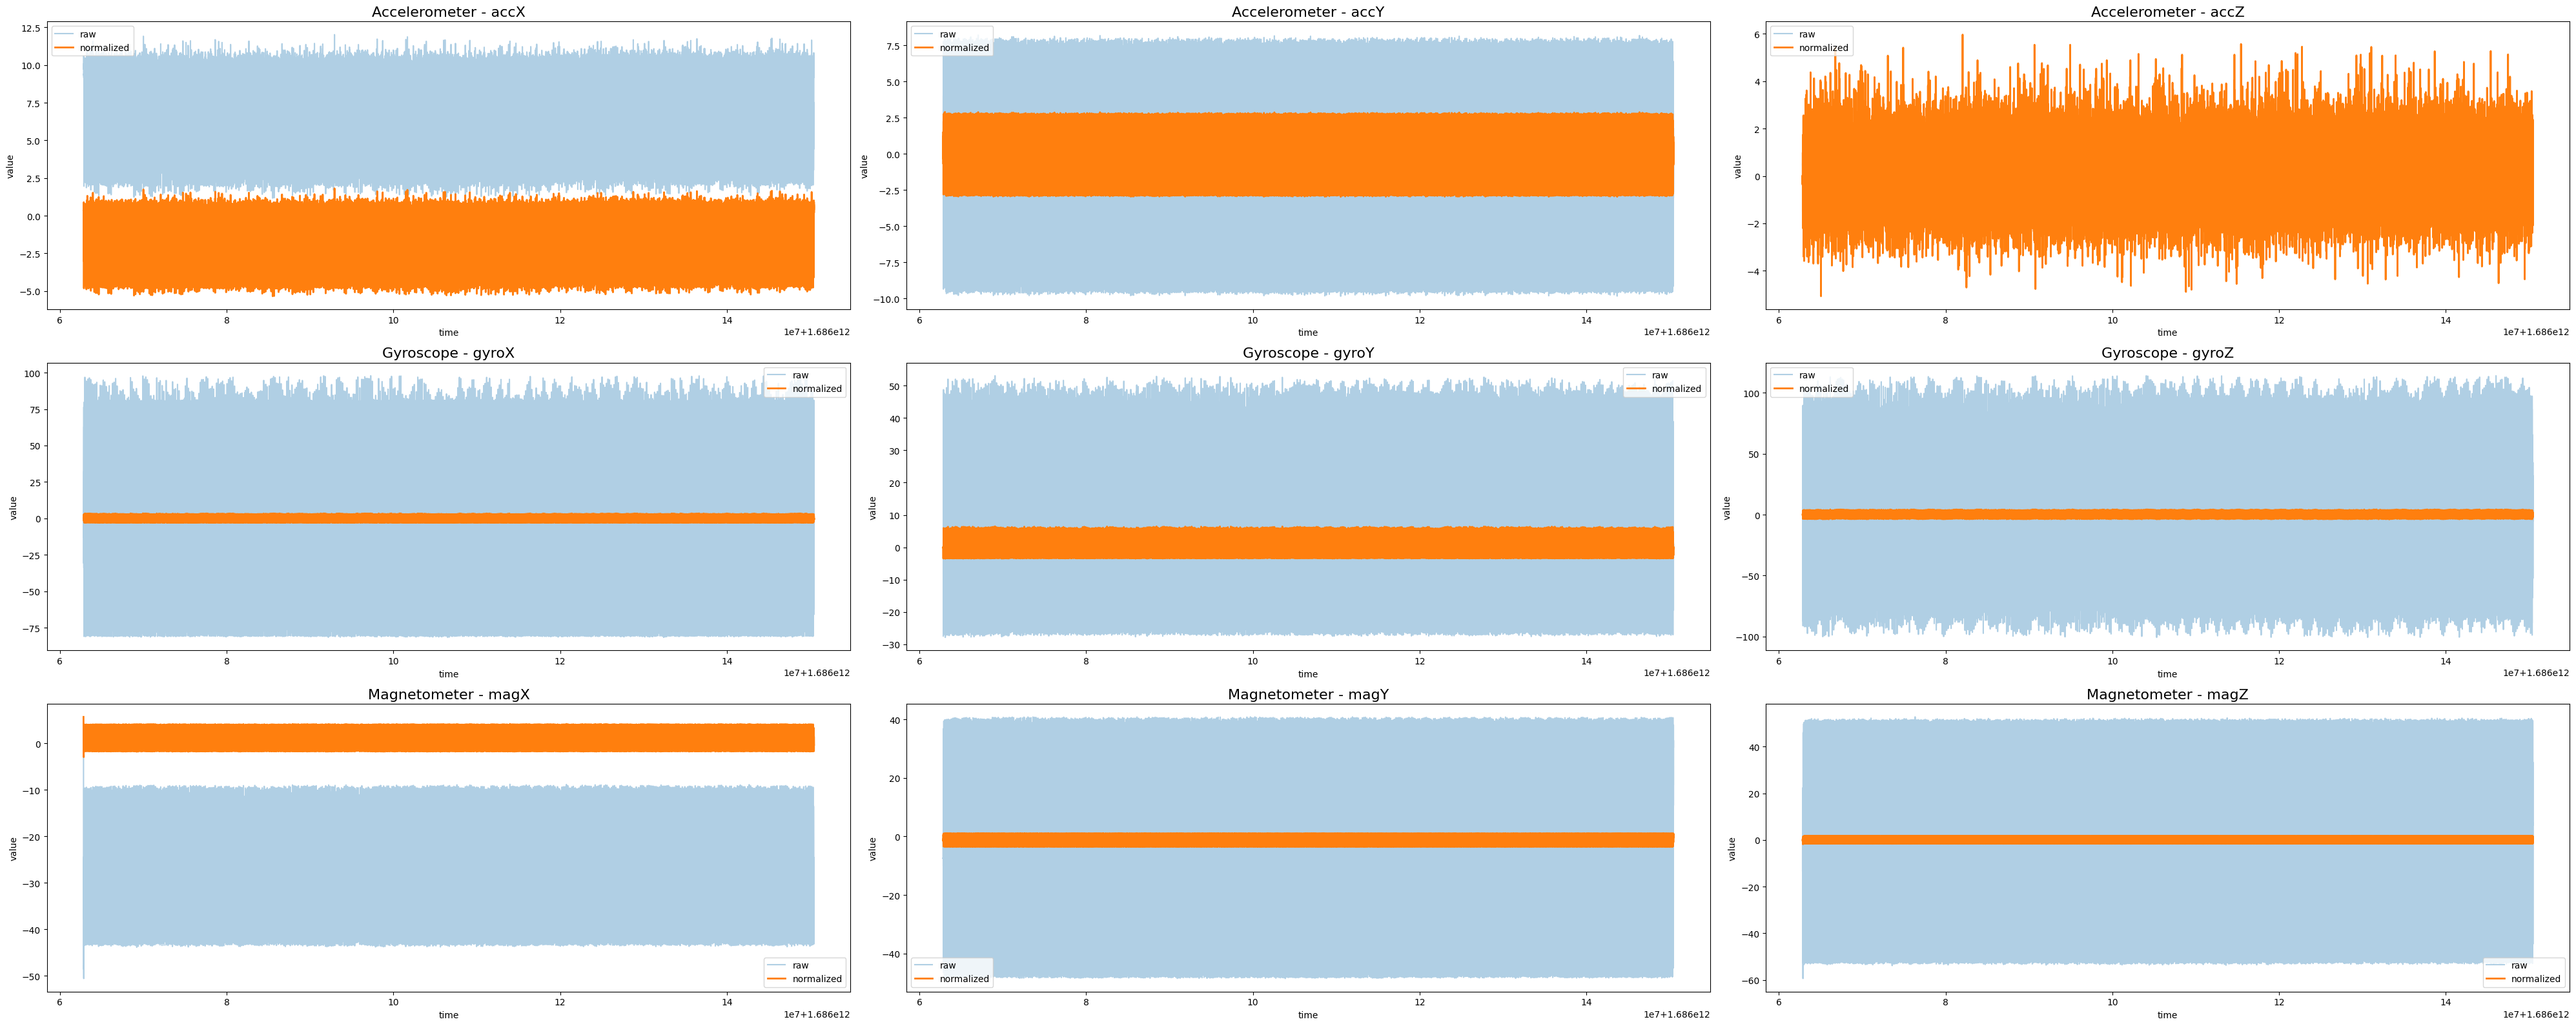

In [22]:
plot_raw_vs_normalized(df)